In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/mai2021/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34330 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:42389 Dashboard: http://127.0.0.1:34330/status,Cluster Workers: 8 Cores: 56 Memory: 251.63 GiB


In [2]:
!squeue -u tuchida

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          11847162      visu      viz  tuchida  R      37:38      1 n4366
8


In [2]:
import numpy as np
import xarray as xr
import qgutils
from xgcm.grid import Grid
import os.path as op
# import dask_image.ndfilters as ndfilters
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/tuchida/msom/msqg/stochas/'

In [4]:
U = .1
T = 5e5      # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 256/2    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
# ntime = 187

In [5]:
ds = xr.open_dataset(op.join(ddir,'outdir_0002/vars.nc'))


ds = ds.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
ds.coords['time'] = ('time',ds.time.data)
ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
ds.coords['drF'] = ('Z',np.array([.06,.14,.8]))
ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
# ds.coords['nmemb'] = ('nmemb',range(nmemb+1))
ds = ds.chunk({'time':10,'YC':128,'XC':128})
ds

<xarray.Dataset>
Dimensions:  (XC: 128, XG: 128, YC: 128, YG: 128, Z: 3, Zp1: 4, time: 6221)
Coordinates:
  * YC       (YC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
  * XC       (XC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 6.218e+03 6.219e+03 6.22e+03
  * YG       (YG) float64 0.0 0.625 1.25 1.875 2.5 ... 77.5 78.12 78.75 79.38
  * XG       (XG) float64 0.0 0.625 1.25 1.875 2.5 ... 77.5 78.12 78.75 79.38
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>

In [6]:
psib = ds.p.mean('time')
qb = ds.q.mean('time')
psip = ds.p - psib
qp = ds.q - qb

dsave = psip.to_dataset(name='psip')
dsave['qp'] = qp
dsave['pb'] = psib
dsave['qb'] = qb
# dsave = dsave.chunk({'YC':128,'XC':128})
print(dsave)
dsave.to_zarr(op.join(ddir,'Mean-Eddy0002/'), mode='w')

<xarray.Dataset>
Dimensions:  (XC: 512, YC: 512, Z: 3, time: 4977)
Coordinates:
  * YC       (YC) float64 0.07812 0.2344 0.3906 0.5469 ... 79.61 79.77 79.92
  * XC       (XC) float64 0.07812 0.2344 0.3906 0.5469 ... 79.61 79.77 79.92
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
Data variables:
    psip     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    qp       (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    pb       (Z, YC, XC) float32 dask.array<chunksize=(3, 128, 128), meta=np.ndarray>
    qb       (Z, YC, XC) float32 dask.array<chunksize=(3, 128, 128), meta=np.ndarray>


In [7]:
dsbp = xr.open_zarr(op.join(ddir,'Mean-Eddy0002'))
jacpp = xr.zeros_like(dsbp.psip).load()
for tt in jacpp.time:
    jacpp.sel(time=tt)[:] = qgutils.jacobian(dsbp.psip.sel(time=tt), dsbp.qp.sel(time=tt), Delta=dx)

AttributeError: 'tuple' object has no attribute 'keys'

In [9]:
dsave = jacpp.drop_vars('drF').chunk(dsbp.psip.chunks).to_dataset(name='jacpp')
print(dsave)
dsave.to_zarr(op.join(ddir,'JacPsipQp0002/'), mode='w')

<xarray.Dataset>
Dimensions:  (XC: 512, YC: 512, Z: 3, time: 4977)
Coordinates:
  * XC       (XC) float64 0.07812 0.2344 0.3906 0.5469 ... 79.61 79.77 79.92
  * YC       (YC) float64 0.07812 0.2344 0.3906 0.5469 ... 79.61 79.77 79.92
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
Data variables:
    jacpp    (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>


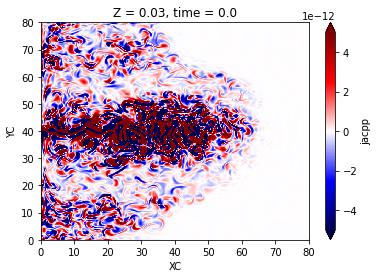

In [20]:
(dsjac.jacpp.isel(time=0,Z=0) * U**2/Rd**2).plot(vmax=5e-12, cmap='seismic')

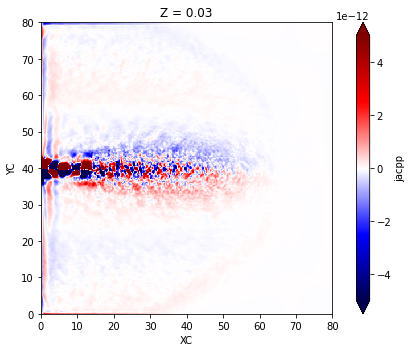

In [8]:
dsjac = xr.open_zarr(op.join(ddir,'JacPsipQp0002/'))
fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
(dsjac.jacpp.isel(Z=0) * U**2/Rd**2).mean('time').plot(vmax=5e-12, cmap='seismic')
ax.set_aspect('equal', adjustable='box')

In [9]:
jacppp = dsjac.jacpp - dsjac.jacpp.mean('time')
jacppp

,Array,Chunk
Bytes,15.66 GB,1.97 MB
Shape,"(4977, 3, 512, 512)","(10, 3, 128, 128)"
Count,26609 Tasks,7968 Chunks
Type,float32,numpy.ndarray


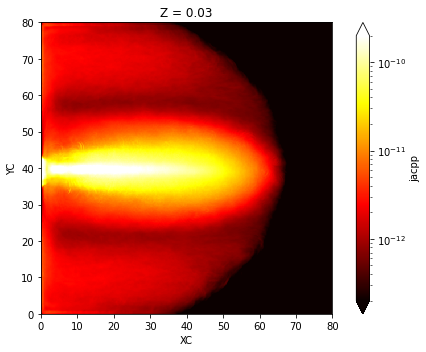

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
(jacppp.isel(Z=0) * U**2/Rd**2).std('time').plot(cmap='hot',
                                                 norm=clr.LogNorm(vmin=2e-13, vmax=2e-10))
ax.set_aspect('equal', adjustable='box')

In [17]:
grid = Grid(ds, periodic=[],
            coords={'T':{'center':'time'},
                    'Z':{'center':'Z','outer':'Zp1'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}})
gridz = Grid(ds.isel(Z=slice(1,-1),Zp1=slice(1,-1)), periodic=[],
             coords={'T':{'center':'time'},
                     'Z':{'center':'Z','outer':'Zp1'},
                     'Y':{'center':'YC','left':'YG'},
                     'X':{'center':'XC','left':'XG'}})

In [18]:
Frm = xr.DataArray(np.array([0.0023669,0.0076173]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))})

N0 = U/(Frm * H*ds.drC.isel(Zp1=slice(1,-1)))

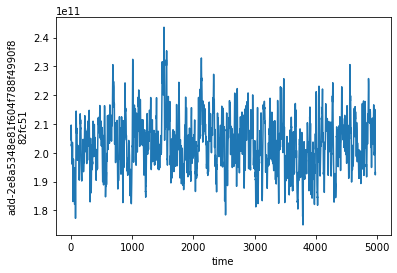

In [23]:
(KE.sum(['YC','XC'])*dx**2 * U**2*Rd**2).plot()

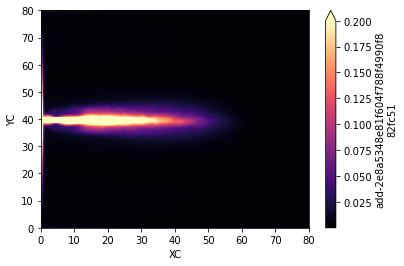

In [24]:
(KE*U**2).mean('time').plot(vmax=.2, cmap='magma')

In [ ]:
KEbar = KE.sel(Z=0.03,YC=slice(20.,60.),XC=slice(None,60.)
              ).mean('nmemb').mean(['YC','XC']).compute()
KEstd_xy = KE.sel(Z=0.03,YC=slice(20.,60.),XC=slice(None,60.)
                 ).mean(['YC','XC']).std('nmemb').compute()
KEstd = KE.sel(Z=0.03,YC=slice(20.,60.),XC=slice(None,60.)
              ).std('nmemb').mean(['YC','XC']).compute()

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for i in range(nmemb+1):
    if i < nmemb:
        ax.plot(ds.time/(365*86400), KE.sel(Z=.03,YC=slice(20.,60.),XC=slice(0.,60.)
                                           ).isel(nmemb=i).mean(['YC','XC']))
    else:
        ax.plot(ds.time/(365*86400), KE.sel(Z=.03,YC=slice(20.,60.),XC=slice(0.,60.)
                                           ).isel(nmemb=i).mean(['YC','XC']), 
                'r--', label=r'ctrl', lw=3)

ax.plot(ds.time/(365*86400), KEbar, 
        'k--', lw=2, label=r'$\overline{KE}$')
ax.fill_between(ds.time/(365*86400), 
                (KEbar.mean(['YC','XC'])-KEstd_xy),
                (KEbar.mean(['YC','XC'])+KEstd_xy), 
                color='grey', alpha=.5)
ax2.plot(ds.time/(365*86400), KEstd, 
         'b-.', lw=3, label=r"$\sigma_{KE}$")

ax.set_xlim([0.,8.])
ax2.set_ylim([0.,.045])
ax.legend(loc='upper left', fontsize=14)
ax2.legend(loc='lower right', fontsize=14)
ax2.spines['right'].set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax.set_xlabel(r"[yr]", fontsize=12)
ax.grid(True)
plt.savefig(op.join(ddir,'../Figs/KE_seas_%03dmembs.pdf' % nmemb))

In [9]:
client.close()